# Combing data and analysing

The cleaned CSVs obtained from 1_extract_clk_data and 2_extract_ext_data can be combined and used to perform statistical analysis. This notebook does the following

* Joining external and clickstream data
* Adding new features and indices
* Filtering to a subset
* Performing some statistical analysis


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import ttest_ind,pearsonr, kendalltau, spearmanr
from helper_files import checkLinearFit

# Inputs

external_csv = r"C:\Users\Andris\Documents\GitHub\data\clean\school_ext_data.csv"
internal_csv = r"C:\Users\Andris\Documents\GitHub\data\clean\school_clk_data.csv"


In [83]:
# ------------------------------------------------------
# JOIN EXTERNAL DATA WITH CLICKSTREAM DATA
# ------------------------------------------------------

# Read external data (indices and exam results)
df_ext = pd.read_csv(external_csv)

# Read internal data (clickstream data)
df_int = pd.read_csv(internal_csv)

# Combine the 2 dataframes
df_ext['URN'] = df_ext['URN'].astype('str') 
df = df_ext.set_index('URN').join(df_int.set_index('school_id'))

# ------------------------------------------------------
# ADDING NEW FEATURES AND INDICES
# ------------------------------------------------------

# Computing improvement in exam scores

qu = ['Biology','Mathematics','Chemistry','Physics']

for item in qu:
    df['exam_improv_' + item] = (df['exam_score|2016_'+item] - df['exam_score|2014_'+item]) - (df['exam_score|2016_'+item] - df['exam_score|2014_'+item]).mean()

# Computing index of achievement

for item in qu:
    df['I_A_'+item] = (df['exam_improv_' + item] + 0.5) + (df['exam_score|2016_' + item]) 
    
# Teacher activity
df['teacher_activity'] = (df.filter(regex='q_lvl_[0-6]_tch|_cor_tch').sum(axis=1)/df['user_id_tch']).fillna(0)
df['teacher_other'] = (df[['add_user','create_group','add_custom_assig','add_assig','view_assig_prog']].sum(axis=1)/df['user_id_tch']).fillna(0)

# Student activity
df['student_activity'] =  (df.filter(regex='_cor_std').sum(axis=1)/df['Entries|2016_Physics']).fillna(0)
df['student_other'] =  (df[['play_video_std','view_concept_std']].sum(axis=1)/df['Entries|2016_Physics']).fillna(0)

# ------------------------------------------------------
# CLEANING THE DATA
# ------------------------------------------------------

#  Remove all schools that have no IDACI rating
df = df[pd.notnull(df['IDACI'])]

#  All clickstream data that is not defined is set to 0
df = df.fillna(0)

# Select the schools that have provide all science courses in 2016
df = df[(df['Entries|2016_Biology']>0)&(df['Entries|2016_Physics']>0)&(df['Entries|2016_Chemistry']>0)&(df['Entries|2016_Mathematics']>0)]

# Select only those schools that also provide science courses in 2015
df = df[(df['Entries|2014_Biology']>0)&(df['Entries|2014_Physics']>0)&(df['Entries|2014_Chemistry']>0)&(df['Entries|2014_Mathematics']>0)]

# Removing schools with high exam scores
#df = df[(df.filter(regex='exam_score')<0.7).all(axis=1)]

# Schools with more than 10 entries
#df = df[(df.filter(regex='Entries')>10).all(axis=1)]

# Remove any unecessary features
df = df.drop(df.filter(regex='Entries|exam_score'),axis=1)

# ------------------------------------------------------
# FURTHER CLEANING
# ------------------------------------------------------



# Creating another dataframe that has removed outliers (who fall outside the 95% percentile)
q = df[['teacher_activity','teacher_other','student_activity','student_other']].quantile(0.95)

df_out = df[(df[q.keys()] < q).all(axis=1)]

# Print dataframe features
print('Total number of schools (with outliers):',df.shape[0])
print('Total number of features (with outliers):',df.shape[1])

print('Total number of schools (no outliers):',df_out.shape[0])
print('Total number of features (no outliers):',df_out.shape[1])

# Print the first 5 rows of the dataframe
df.head(5)


Total number of schools (with outliers): 695
Total number of features (with outliers): 58
Total number of schools (no outliers): 621
Total number of features (no outliers): 58


,IDACI,Effectiveness,Teach_quality,L_M_index,PercentageFSM,q_lvl_2_cor_tch,view_concept_tch,q_lvl_3_cor_tch,q_lvl_2_tch,q_lvl_0_cor_tch,...,exam_improv_Chemistry,exam_improv_Physics,I_A_Biology,I_A_Mathematics,I_A_Chemistry,I_A_Physics,teacher_activity,teacher_other,student_activity,student_other
URN,,,,,,,,,,,,,,,,,,,,,
100052,5.0,2.0,2.0,2.0,21.7,0.0,0.0,0.0,0.0,0.0,...,-0.065216,-0.016097,0.836306,1.039002,0.872284,0.775570,0.0,0.000000,0.000000,0.000000
100054,5.0,1.0,1.0,1.0,19.7,1.0,8.0,1.0,3.0,0.0,...,-0.013061,-0.053999,0.915254,1.203970,1.176594,1.091301,6.5,16.000000,17.307692,11.871795
100190,4.0,2.0,2.0,2.0,20.7,12.0,7.0,0.0,15.0,0.0,...,0.002225,0.120477,1.098012,0.959003,1.115861,1.213070,50.0,42.000000,0.000000,0.000000
100279,4.0,2.0,2.0,2.0,21.2,3.0,2.0,10.0,6.0,28.0,...,0.005496,0.002422,1.017033,1.137334,1.135931,1.127422,85.0,16.333333,20.812500,17.312500
100977,5.0,1.0,1.0,1.0,30.2,0.0,1.0,0.0,0.0,20.0,...,-0.100234,0.014194,0.963758,0.995231,0.885582,1.080861,38.0,32.000000,25.400000,11.700000


## Statistical Analysis

Perform some statistical analysis on the dataset. This is seperated into 

* Evaluating correlation and their respective p values
* Evaluating difference in mean between 2 populations (active IP users and non-active users)

### Analysing correlations

Correlationg and their p values can be performed. Important things to note

* Correlation may be different according to method (Pearson, Kendall Tau or Spearman Rank).
* Outliers can affect correlation coefficient.
* The affect of IP may be radically different for different subsets. 


In [84]:
# Choose whether to incorporate outliers or not
df_test = df_out

df_test.corr(method='spearman')['I_A_Physics'].sort_values(ascending=False)


I_A_Physics                1.000000
exam_improv_Physics        0.867333
I_A_Mathematics            0.501000
I_A_Chemistry              0.419943
exam_improv_Mathematics    0.370199
I_A_Biology                0.327608
exam_improv_Chemistry      0.286261
q_lvl_5_std                0.209429
q_lvl_5_cor_std            0.207462
q_lvl_6_cor_std            0.200289
q_lvl_3_cor_std            0.189909
q_lvl_6_std                0.186846
view_hint_std              0.186656
student_activity           0.181926
q_lvl_1_cor_std            0.179304
q_lvl_4_std                0.176602
user_id_std                0.175139
q_lvl_0_cor_std            0.173659
q_lvl_0_std                0.173573
view_concept_std           0.168153
q_lvl_2_cor_std            0.167402
q_lvl_2_std                0.164015
play_video_std             0.163054
q_lvl_4_cor_std            0.162929
q_lvl_1_std                0.162672
student_other              0.162159
q_lvl_3_std                0.161792
exam_improv_Biology        0

In [85]:
# Calculating p values

def test_correlation(df, x_array, y_array, corrType):
    
    store_array = []
    
    for item_x in x_array:
        for item_y in y_array:
            score, pval = corrType(df[item_x],df[item_y])
            store_array.append([item_x, item_y, score,pval])
            
    df = pd.DataFrame(store_array,columns=['x','y','Correlation','P Value'])
            
    return df

# No outliers
print('No outliers')
print(test_correlation(df_out, ['student_activity','teacher_activity'], df_test.filter(regex='I_A').columns, pearsonr))
print(test_correlation(df_out, ['student_activity','teacher_activity'], df_test.filter(regex='I_A').columns, spearmanr))


# With outliers
print('With outliers')
print(test_correlation(df, ['student_activity','teacher_activity'], df_test.filter(regex='exam_improv').columns, pearsonr))
print(test_correlation(df, ['student_activity','teacher_activity'], df_test.filter(regex='exam_improv').columns, kendalltau))




No outliers
                  x                y  Correlation   P Value
0  student_activity      I_A_Biology     0.080523  0.044874
1  student_activity  I_A_Mathematics     0.110170  0.005991
2  student_activity    I_A_Chemistry     0.081894  0.041341
3  student_activity      I_A_Physics     0.151503  0.000151
4  teacher_activity      I_A_Biology     0.065886  0.100933
5  teacher_activity  I_A_Mathematics     0.013945  0.728718
6  teacher_activity    I_A_Chemistry     0.042554  0.289704
7  teacher_activity      I_A_Physics     0.042193  0.293813
                  x                y  Correlation       P Value
0  student_activity      I_A_Biology     0.212142  9.462552e-08
1  student_activity  I_A_Mathematics     0.177539  8.557252e-06
2  student_activity    I_A_Chemistry     0.182889  4.493777e-06
3  student_activity      I_A_Physics     0.181926  5.053205e-06
4  teacher_activity      I_A_Biology     0.040464  3.140629e-01
5  teacher_activity  I_A_Mathematics     0.038896  3.331969e-01


,Coef,R^2,X,Y,intercept
0,0.001356,0.004341,teacher_activity,I_A_Biology,1.071695
1,0.000262,0.000194,teacher_activity,I_A_Mathematics,1.136958
2,0.000956,0.001811,teacher_activity,I_A_Chemistry,1.085002
3,0.001112,0.001780,teacher_activity,I_A_Physics,1.058537
4,0.000956,0.003874,teacher_other,I_A_Biology,1.072391
5,-0.000103,0.000054,teacher_other,I_A_Mathematics,1.137972
6,0.000645,0.001479,teacher_other,I_A_Chemistry,1.085583
7,0.001460,0.005501,teacher_other,I_A_Physics,1.057044
8,0.000798,0.006484,student_activity,I_A_Biology,1.070293
9,0.000996,0.012137,student_activity,I_A_Mathematics,1.131390


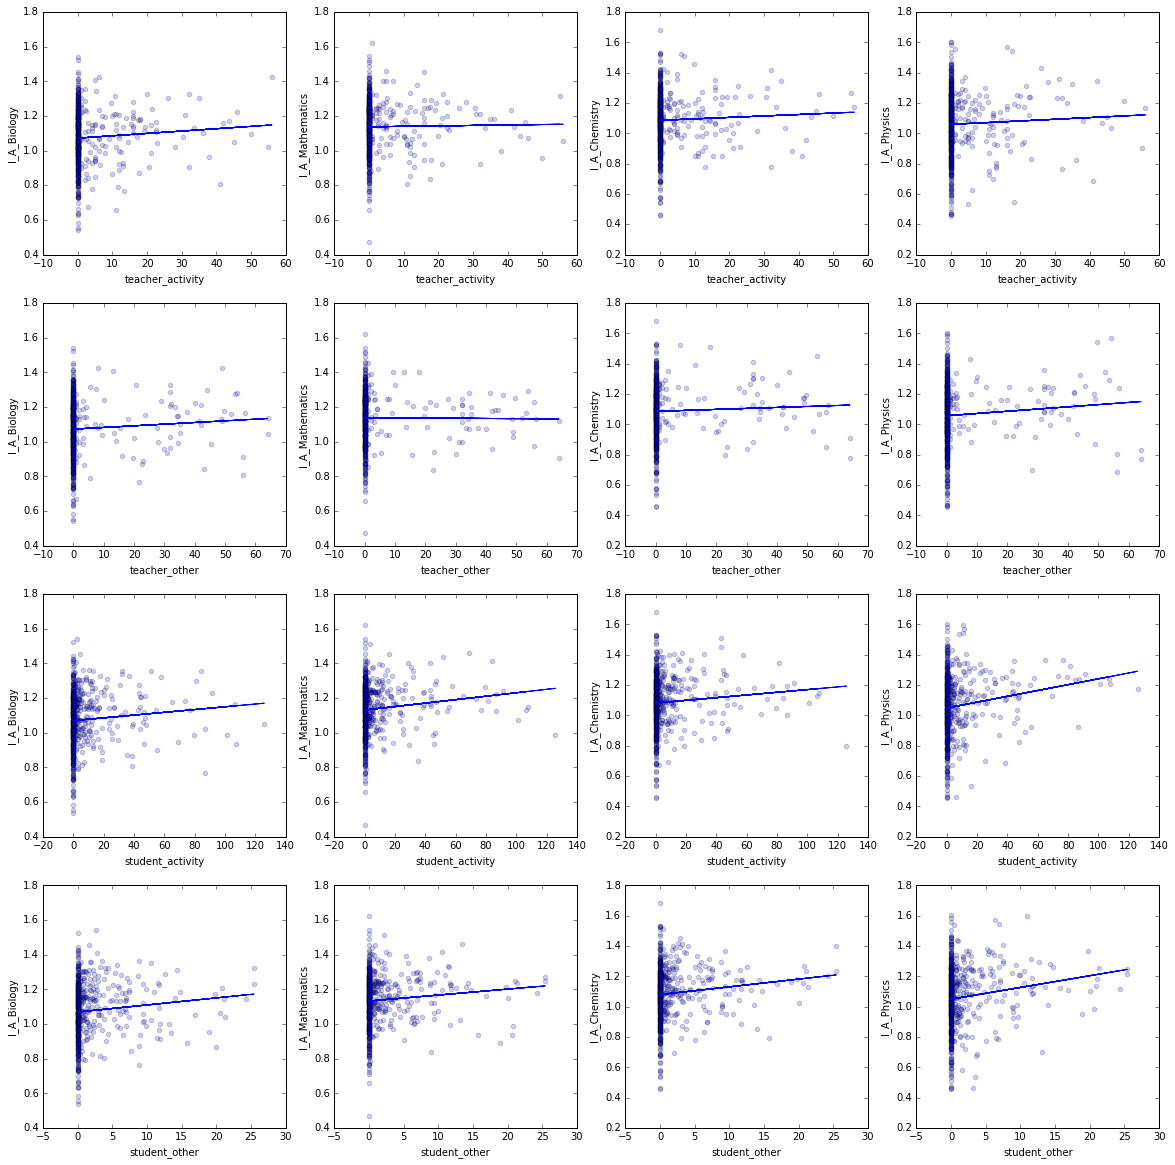

In [93]:
# Checking linear fit with no outliers

feature = ['teacher_activity','teacher_other','student_activity','student_other']

df_test = df_out

df_score = checkLinearFit(df_test,feature,df_test.filter(like='I_A').columns, n_cols=4, n_rows=4,figsize=(20,20))
df_score

,Coef,R^2,X,Y,intercept
0,-0.000196,0.007210,teacher_activity,exam_improv_Biology,-0.005284
1,0.000087,0.002104,teacher_activity,exam_improv_Mathematics,-0.006429
2,-0.000059,0.000672,teacher_activity,exam_improv_Chemistry,0.000191
3,0.000063,0.000462,teacher_activity,exam_improv_Physics,-0.007542
4,-0.000265,0.003567,teacher_other,exam_improv_Biology,-0.005682
5,0.000355,0.009391,teacher_other,exam_improv_Mathematics,-0.007664
6,-0.000079,0.000331,teacher_other,exam_improv_Chemistry,0.000070
7,-0.000020,0.000012,teacher_other,exam_improv_Physics,-0.006784
8,-0.000002,0.000031,student_activity,exam_improv_Biology,-0.007200
9,0.000029,0.012034,student_activity,exam_improv_Mathematics,-0.006544


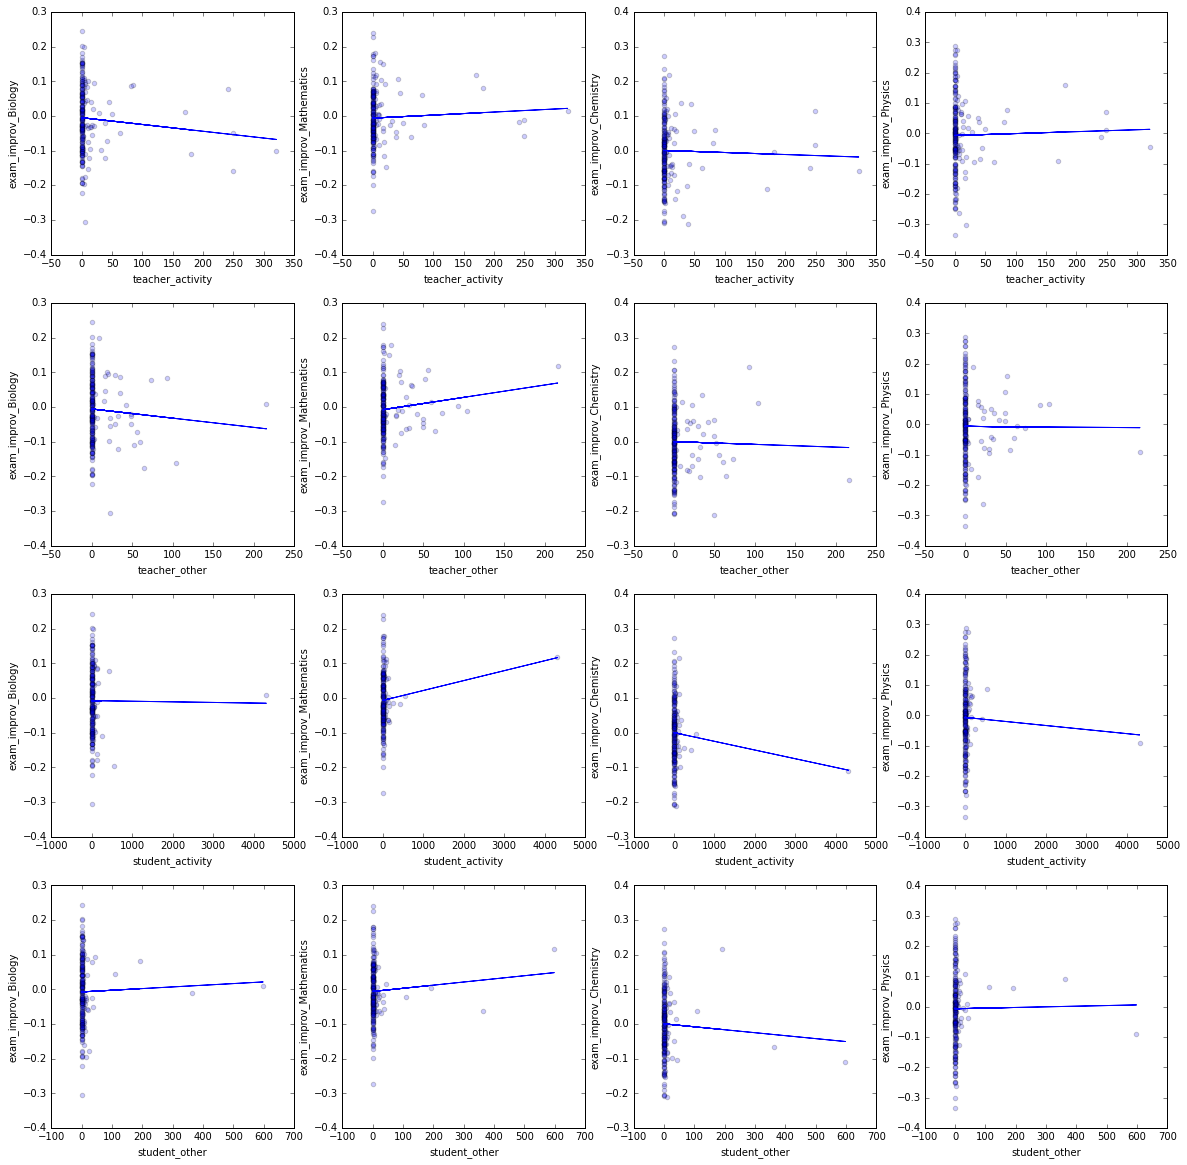

In [27]:
# Checking linear fit with outliers

feature = ['teacher_activity','teacher_other','student_activity','student_other']


df_score = checkLinearFit(df,feature,df.filter(like='exam').columns, n_cols=4, n_rows=4,figsize=(20,20))
df_score

## Analysing Populations

The schools can be binned into 2 seperate populations as active users, non-active users and semi-active users. 
Then the mean difference between the populations can be evaluated with an ANOVA test.  



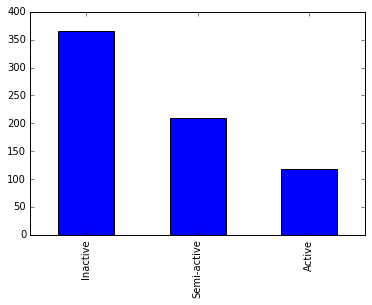

In [94]:
# Bin the schools into seperate categories

def bin_groups(df, feature, bins, group_names):
    
    categories = pd.cut(df[feature],bins, labels=group_names)
    return categories


# ------------------------------------------------------
# Choose a feature and determine distribution
# ------------------------------------------------------

bins = [-0.1, 0, 20,1000]
group_names = ['Inactive','Semi-active','Active']

df['categories'] = bin_groups(df,'student_activity',bins,group_names)

# Plot a histogram
df['categories'].value_counts().plot(kind='bar')



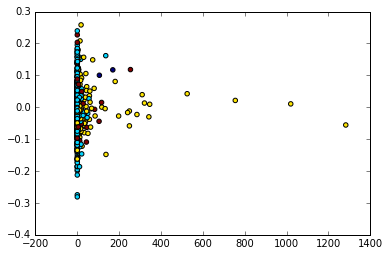

In [92]:
# Plotting a scatter plot to visualise any clusters

colors = pd.factorize(df['categories'])[0]
plt.scatter(df['teacher_activity'],df['exam_improv_Mathematics'],c=colors)

Mean of inactive: 1.031023918579234
Mean of active: 1.1260233185259052


Ttest_indResult(statistic=-4.9922018615390913, pvalue=1.1151002316437101e-06)

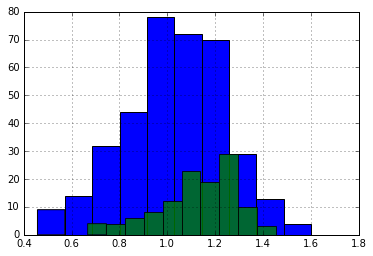

In [95]:
# Plot the histograms of the 2 populations and do a t-test

feature = 'exam_improv_Physics'
feature = 'I_A_Physics'

df[df['categories']=='Inactive'][feature].hist(bins=10)
df[df['categories']=='Active'][feature].hist(alpha=0.8,bins=10)

print('Mean of inactive:',df[df['categories']=='Inactive'][feature].mean())
print('Mean of active:',df[df['categories']=='Active'][feature].mean())

ttest_ind(df[df['categories']=='Inactive'][feature],df[df['categories']=='Active'][feature],equal_var=False)


Mean of inactive: 1.043248068038367
Mean of active: 1.1099007060625117


Ttest_indResult(statistic=-3.8065266441687737, pvalue=0.00018763433653558315)

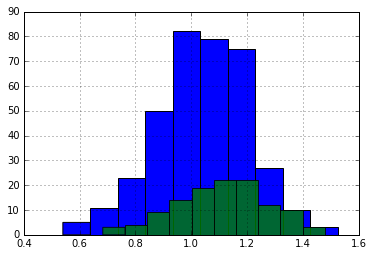

In [96]:
# Plot the histograms of the 2 populations and do a t-test

feature = 'exam_improv_Chemistry'
feature = 'I_A_Biology'

df[df['categories']=='Inactive'][feature].hist(bins=10)
df[df['categories']=='Active'][feature].hist(alpha=0.8,bins=10)

print('Mean of inactive:',df[df['categories']=='Inactive'][feature].mean())
print('Mean of active:',df[df['categories']=='Active'][feature].mean())

ttest_ind(df[df['categories']=='Inactive'][feature],df[df['categories']=='Active'][feature],equal_var=False)


In [92]:
# Doing an F-test on all variables of interest

from sklearn.feature_selection import f_classif


df_test = df[df['categories']!= 'Semi-active']

X = df_test.filter(regex='I_A')
y = [1 if item == 'Active' else 0 for item in df_test['categories']]
print('Keys:',X.keys())
F, pval = f_classif(X, y)
print('F score is ',F)
print('Corresponding p values',pval)

Keys: Index(['I_A_Biology', 'I_A_Mathematics', 'I_A_Chemistry', 'I_A_Physics'], dtype='object')
F score is  [ 14.57316621  13.6459693   17.45232009  19.08078706]
Corresponding p values [  1.52359617e-04   2.45939426e-04   3.49667975e-05   1.53445504e-05]


In [11]:
q = df[['teacher_activity','teacher_other','student_activity','student_other']].quantile(0.95)


,IDACI,Effectiveness,Teach_quality,L_M_index,PercentageFSM,q_lvl_2_cor_tch,view_concept_tch,q_lvl_3_cor_tch,q_lvl_2_tch,q_lvl_0_cor_tch,...,play_video_std,exam_improv_Biology,exam_improv_Mathematics,exam_improv_Chemistry,exam_improv_Physics,teacher_activity,teacher_other,student_activity,student_other,categories
URN,,,,,,,,,,,,,,,,,,,,,
100054,5.0,1.0,1.0,1.0,19.7,1.0,8.0,1.0,3.0,0.0,...,438.0,-0.075617,-0.063231,0.004101,-0.087845,6.5,16.000000,17.307692,11.871795,Semi-active
100190,4.0,2.0,2.0,2.0,20.7,12.0,7.0,0.0,15.0,0.0,...,0.0,0.005374,-0.019282,0.056830,0.013295,50.0,42.000000,0.000000,0.000000,Inactive
100192,4.0,2.0,2.0,2.0,22.2,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.092524,-0.042368,-0.139522,-0.003901,0.0,0.000000,0.000000,0.000000,Inactive
100279,4.0,2.0,2.0,2.0,21.2,3.0,2.0,10.0,6.0,28.0,...,262.0,0.088169,-0.027284,0.058434,0.077753,85.0,16.333333,20.812500,17.312500,Active
100637,5.0,1.0,1.0,1.0,12.2,0.0,0.0,0.0,0.0,0.0,...,6.0,-0.181960,-0.068970,-0.208883,-0.125594,0.0,0.000000,1.500000,1.666667,Semi-active
100750,4.0,1.0,1.0,1.0,10.5,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.142105,-0.113347,-0.092904,-0.334589,0.0,0.000000,0.000000,0.000000,Inactive
100977,5.0,1.0,1.0,1.0,30.2,0.0,1.0,0.0,0.0,20.0,...,103.0,-0.120846,-0.061349,-0.101855,0.049869,38.0,32.000000,25.400000,11.700000,Active
100979,5.0,3.0,3.0,3.0,51.4,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.144563,-0.172450,-0.078411,-0.227446,0.0,0.000000,0.000000,0.000000,Inactive
101053,4.0,1.0,2.0,1.0,13.6,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.112516,-0.199312,-0.040533,-0.197816,0.0,0.000000,0.000000,0.000000,Inactive
